In [ ]:
# based on : https://towardsdatascience.com/push-the-accuracy-of-machine-learning-model-with-numerical-variable-transformation-in-pytorch-9f56c56203fd
# The tutorial examines the affect of different prior data-transformation on regression problem.
# Boston Housing data set contains information of various houses in Boston.
# There are 506 samples and 13 feature variables.
# The objective is to predict the house’s prices using the given features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset

DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
# read data
DATA_FILENAME = "Boston_Housing.csv"
TARGET_COLUMN = 'medv'
dataframe = pd.read_csv(DATASET_URL)
dataframe.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


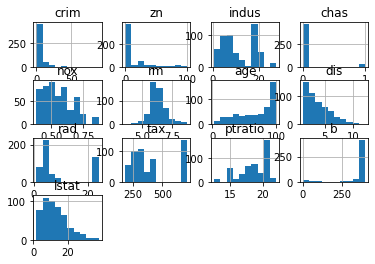

In [144]:
dataframe.drop('medv', axis=1).hist();
dataframe.columns
df = dataframe.drop('medv', axis=1)
#inputs = transformer.fit_transform(df.values)
#inputsdf = pd.DataFrame(inputs, columns=list(df.columns))#, columns=dataframe.columns)

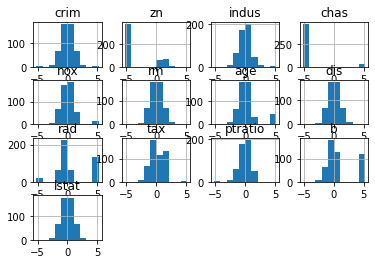

In [140]:
#inputsdf.hist();

In [124]:
class HousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, xb):
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss.detach()

    def epoch_end(self, epoch, epochs, result):
        print("Epoch {}/{} \n Train_loss: {:.4f}  Validation_loss: {:.4f}".format(epoch+1, epochs, result['train_loss'], result['val_loss'] ))

In [ ]:
# Evaluation function
def evaluate(model, train_loader, val_loader):
    train_loss_batch = [model.validation_step(batch) for batch in train_loader]
    train_loss = torch.stack(train_loss_batch).mean()
    val_loss_batch = [model.validation_step(batch) for batch in val_loader]
    val_loss = torch.stack(val_loss_batch).mean()
    return {'train_loss': train_loss.item(), 'val_loss': val_loss.item()}

# Training function
def train(epochs, lr, model, train_loader, val_loader, opt_func= torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    print('Training...')
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, train_loader, val_loader)
        model.epoch_end(epoch,epochs, result)
        history.append(result)
    return history

def plot_results( history, comment=None):
    res= np.array([[raw['train_loss'], raw['val_loss']] for raw in history])
    respd= pd.DataFrame(res,columns=['train','validation'])
    stitle = 'Loss on predicting the house’s prices' + (" - " + comment if comment else "")
    respd.plot(xlabel='epoc', ylabel='loss', title=stitle)

Training...
Epoch 1/10 
 Train_loss: 173.0638  Validation_loss: 149.2467
Epoch 2/10 
 Train_loss: 79.5683  Validation_loss: 73.7331
Epoch 3/10 
 Train_loss: 78.7847  Validation_loss: 75.2591
Epoch 4/10 
 Train_loss: 76.3086  Validation_loss: 74.4542
Epoch 5/10 
 Train_loss: 79.7157  Validation_loss: 75.0962
Epoch 6/10 
 Train_loss: 75.1791  Validation_loss: 75.1348
Epoch 7/10 
 Train_loss: 79.6050  Validation_loss: 75.5114
Epoch 8/10 
 Train_loss: 75.1027  Validation_loss: 75.3756
Epoch 9/10 
 Train_loss: 79.2310  Validation_loss: 75.9705
Epoch 10/10 
 Train_loss: 71.8516  Validation_loss: 75.6021
Training...
Epoch 1/10 
 Train_loss: 194.4314  Validation_loss: 159.2491
Epoch 2/10 
 Train_loss: 139.2111  Validation_loss: 120.2606
Epoch 3/10 
 Train_loss: 109.4660  Validation_loss: 103.6596
Epoch 4/10 
 Train_loss: 101.4256  Validation_loss: 94.8186
Epoch 5/10 
 Train_loss: 93.6154  Validation_loss: 83.3607
Epoch 6/10 
 Train_loss: 95.3928  Validation_loss: 84.8798
Epoch 7/10 
 Train_los

<Figure size 432x288 with 0 Axes>

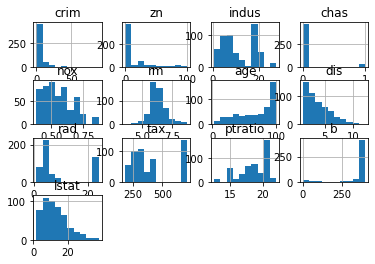

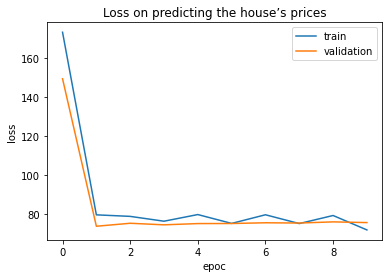

<Figure size 432x288 with 0 Axes>

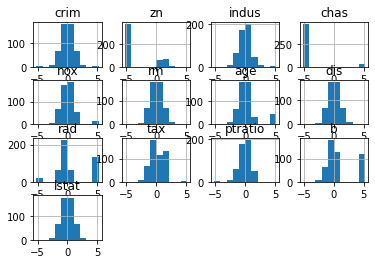

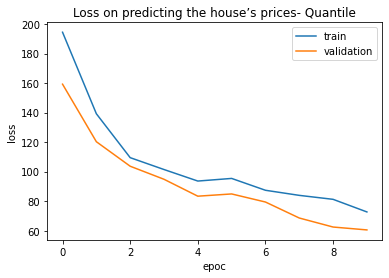

<Figure size 432x288 with 0 Axes>

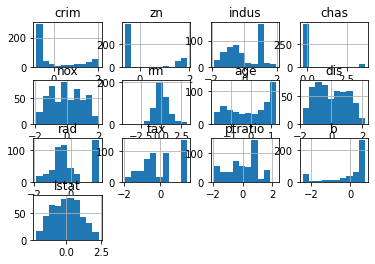

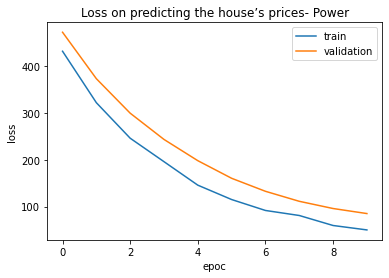

<Figure size 432x288 with 0 Axes>

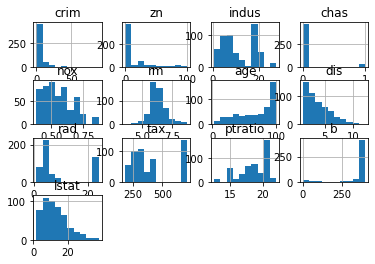

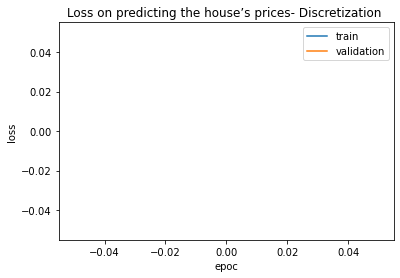

In [150]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

trans_name = [None, 'Quantile', 'Power', 'Discretization ']
lrs = [5e-7,1e-2,1e-2,1e-3]

for trans, lr in zip(trans_name,lrs):

    # Convert from Pandas dataframe to numpy arrays
    raw_inputs = df.values
    if trans=='Quantile':
        transformer = QuantileTransformer(n_quantiles=100, output_distribution='normal')
        inputs = transformer.fit_transform(raw_inputs)
    elif trans=='Power':
        transformer = PowerTransformer(method='box-cox')
        scaler = MinMaxScaler(feature_range=(1, 2))
        pipeline = Pipeline(steps=[('s', scaler),('t', transformer)])
        inputs = pipeline.fit_transform(raw_inputs)
    elif trans=='Discretization':
        transformer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        inputs = transformer.fit_transform(raw_inputs)
    else:
        inputs = raw_inputs
    plt.figure()
    pd.DataFrame(inputs, columns=list(df.columns)).hist();

    targets = dataframe[['medv']].values

    #hyperparameters
    batch_size=64
    learning_rate= lr# 1e-2 #5e-7
    input_size=13
    output_size=1

    # Convert to PyTorch dataset
    dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
    train_ds, val_ds = random_split(dataset, [406, 100])

    train_loader = DataLoader(train_ds, batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size*2)



    model = HousingModel()
    history = train(10, learning_rate, model, train_loader, val_loader)
    plot_results(history,trans)